## Load in 17344 WT RBD:ACE2 data and get a feel for it

The data here corresponds to 162 trajectories (all trajs > 150 ns).

In [1]:
import pyemma
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load feature array
with open("050621_distances_1.pickle", "rb") as f:
    distances = pickle.load(f)

distances has 162 arrays (one for each traj), and each array has two sub arrays, one for distances, one for residue pairs

In [3]:
for i, pair in enumerate(distances[0][1]):
    if 169 in pair:
        print(i, pair) # 1177 is Y501-Y41

21 [512 169]
83 [513 169]
144 [514 169]
204 [515 169]
263 [517 169]
321 [518 169]
378 [537 169]
434 [234 169]
489 [538 169]
543 [539 169]
596 [540 169]
648 [541 169]
699 [542 169]
749 [543 169]
798 [161 169]
846 [162 169]
893 [163 169]
939 [164 169]
984 [165 169]
1028 [166 169]
1071 [167 169]
1113 [168 169]
1155 [169 170]
1156 [169 171]
1157 [169 172]
1158 [169 173]
1159 [169 174]
1160 [169 175]
1161 [169 176]
1162 [169 544]
1163 [169 545]
1164 [169 574]
1165 [169  69]
1166 [169  70]
1167 [169  71]
1168 [169  72]
1169 [169  73]
1170 [169 581]
1171 [169 222]
1172 [169 223]
1173 [169 225]
1174 [169 226]
1175 [169 227]
1176 [169 228]
1177 [169 229]
1178 [169 230]
1179 [169 231]
1180 [169 232]
1181 [169 105]
1182 [169 106]
1183 [169 107]
1184 [169 108]
1185 [169 233]
1186 [169 110]
1187 [169 111]
1188 [169 112]
1189 [169 113]
1190 [169 114]
1191 [169 115]
1192 [169 116]
1193 [169 117]
1194 [169 118]
1195 [169 119]


In [4]:
distances[0][1][1177]

array([169, 229])

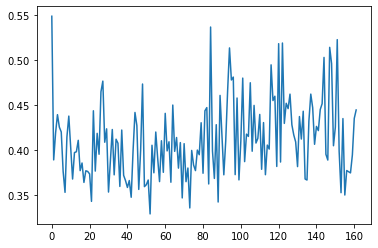

In [5]:
# Check what the timeseries of Y501-Y41 distances looks like for first clone
plt.plot(distances[0][0][:, 1177])
plt.show()

## Now, let's run tica

In [6]:
# The input for tica needs to be a list of lists with the following dimensions:
# (number of trajs, number of frames, number of residue pairs)'

distances_final = np.array([output[0] for output in distances])

for_tica = []
for traj in distances_final:
    traj_distances = []
    for frame in traj:
        frame_distances = []
        for distance in frame:
            frame_distances.append(distance)
        traj_distances.append(frame_distances)
    for_tica.append(traj_distances)


<ipython-input-6-d56774620d51>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  distances_final = np.array([output[0] for output in distances])


In [7]:
tica = pyemma.coordinates.tica(for_tica, lag=1) 

# The lag time (units: number of frames) doesn't matter, make it as short as possible 
# Will need to play around with:
# Kinetic map -- multiplies output coordinate by sqrt(eigenvalue), eigenvalues depend on lag time, so need to find sweet spot where this works best
# Commute map -- removes dependence on lag time by using timescales (multiplies output coordinate by timescales -- slowest thing gets multiplied by fastest timescale, fastest gets multiplied by the slowest timescale)
# dim -- how many tics you get out, -1 means you get out as many tics as numbers of features that capture var_cutoff variance 
# var_cutoff -- % cutoff variance for which to select number of tics

calculate covariances:   0%|          | 0/162 [00:00<?, ?it/s]

In [8]:
tica

TICA(commute_map=False, dim=-1, epsilon=1e-06, kinetic_map=True, lag=1,
   ncov_max=inf, reversible=True, skip=0, stride=1, var_cutoff=0.95,
   weights=None)

In [9]:
tica_output = tica.get_output()

getting output of TICA:   0%|          | 0/162 [00:00<?, ?it/s]

In [10]:
# Let's look at the tica output for the first traj
tica_output[0].shape 
# only 1110 tics used because these capture 95% of variance (tics do not directly correspond to features)
# 162 corresponds to number of frames in the first traj

(162, 1110)

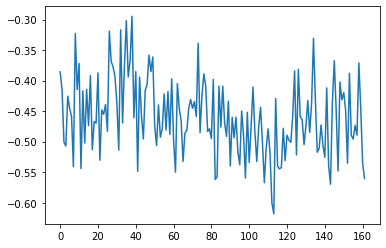

In [11]:
# Plot first tic for each frame for first trajectory
plt.plot(tica_output[0][:,0]) 
# This shows that there is some slowness in this tic -- most of the time its at 0.45

In [12]:
# Now, let's look at the correlation matrix between tics and residue-pairs
tica.feature_TIC_correlation

array([[-6.52904109e-03, -1.34646099e-03, -5.65478318e-03, ...,
        -2.69539854e-03,  1.06560891e-03,  3.66195529e-03],
       [ 8.20907312e-03,  6.63768557e-02,  2.77789425e-02, ...,
         8.41433621e-04,  4.34325510e-03, -2.20766695e-03],
       [-4.11579835e-02, -4.03603456e-02,  4.75648530e-02, ...,
         1.99758135e-04,  2.18421975e-03, -4.92909967e-03],
       ...,
       [-8.96981514e-03, -2.44713108e-03,  1.41463159e-04, ...,
         3.52952140e-03,  1.23812172e-03, -2.71939323e-03],
       [ 3.60405717e-01, -3.85069236e-02, -3.35002150e-03, ...,
         2.97774123e-04,  3.01268782e-03, -5.17653937e-04],
       [-1.26984426e-02,  6.58336280e-04, -6.56197500e-04, ...,
        -2.05857696e-03, -1.95307858e-03, -4.04755559e-03]])

In [13]:
tica.feature_TIC_correlation.shape # 2016 distances, 1110 tics

(2016, 1110)

In [14]:
# Check the correlations between each residue-pair and the first tic
tica.feature_TIC_correlation[:,0]

array([-0.00652904,  0.00820907, -0.04115798, ..., -0.00896982,
        0.36040572, -0.01269844])

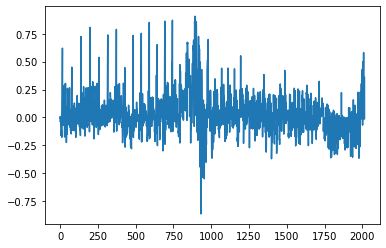

In [38]:
# Plot the correlation with tic 0 vs. residue-pair
plt.plot(tica.feature_TIC_correlation[:,0]) 
# Note the points in the plots should not be connected
# Many slow reaction coordinate

In [41]:
np.where(tica.feature_TIC_correlation[:,0] > 0.75)

(array([198, 372, 537, 590, 693, 743, 890, 891, 892, 893, 901, 902]),)

In [43]:
for i in distances[0][1][[198, 372, 537, 590, 693, 743, 890, 891, 892, 893, 901, 902]]:
    print(i)

[515 163]
[537 163]
[539 163]
[540 163]
[542 163]
[543 163]
[163 166]
[163 167]
[163 168]
[163 169]
[163 544]
[163 545]


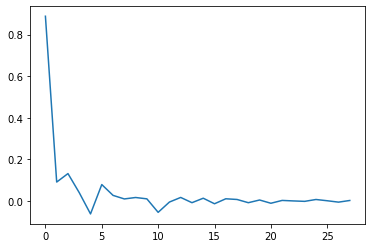

In [62]:
# Plot the correlation with residue-pair 55 vs. tic
plt.plot(tica.feature_TIC_correlation[55,:])

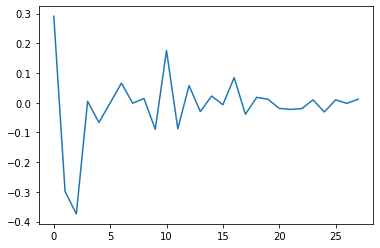

In [63]:
# Plot the correlation with residue-pair 5 vs. tic
plt.plot(tica.feature_TIC_correlation[5,:])
# residue pair 5 is somewhat correlated with tic 0, meaning it may contribute to a little to the slowest processes

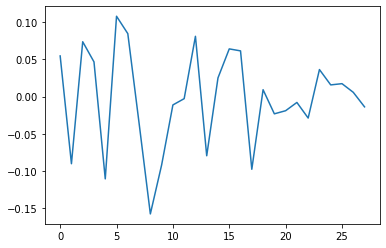

In [66]:
# Plot the correlation with residue-pair 2 vs. tic
plt.plot(tica.feature_TIC_correlation[2,:])
# residue pair 0 is not correlated with any of the tics, meaning it doesn't contribute much to the slowest processes

In [87]:
for_tica[0][0]

136

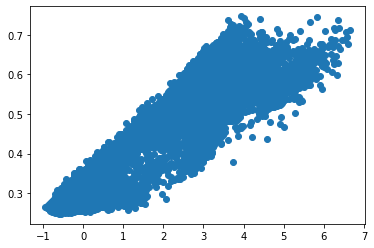

In [89]:
# For all frames, plot distance for residue pair 55 vs. the first tic
plt.scatter(np.concatenate([traj[:, 0] for traj in tica_output]), [frame[55] for traj in for_tica for frame in traj]) 
# These are correlated -- which matches what we observed above by using the correlation coefficient matrix
# to plot correlation with tic 0 vs. residue-pair

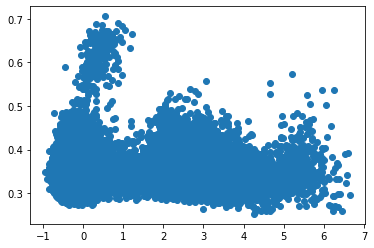

In [90]:
# For all frames, plot distance for residue pair 2 vs. the first tic
plt.scatter(np.concatenate([traj[:, 0] for traj in tica_output]), [frame[2] for traj in for_tica for frame in traj])
# Little to no correlation -- which matches what we observed above by using the correlation coefficient matrix
# to plot correlation with tic 0 vs. residue-pair

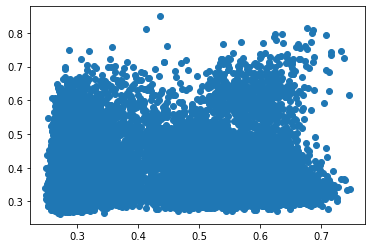

In [91]:
# Plot distance for the 55th residue pair vs. distance for the 5th residue-pair
plt.scatter([frame[55] for traj in for_tica for frame in traj], [frame[5] for traj in for_tica for frame in traj])


(array([7.9523e+04, 3.1002e+04, 8.7300e+02, 1.3940e+03, 4.4500e+03,
        2.6930e+03, 8.3100e+02, 4.5300e+02, 2.6300e+02, 4.8000e+01]),
 array([-0.9409308 , -0.18199858,  0.5769336 ,  1.3358659 ,  2.094798  ,
         2.8537302 ,  3.6126623 ,  4.3715944 ,  5.130527  ,  5.889459  ,
         6.6483912 ], dtype=float32),
 <BarContainer object of 10 artists>)

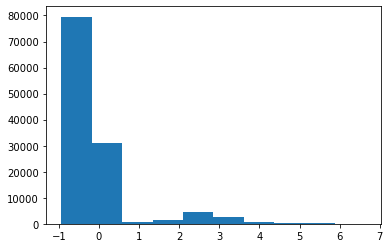

In [92]:
# Plot distribution of first tic for all the data
plt.hist(np.concatenate([traj[:, 0] for traj in tica_output]))

(array([107., 140.,  27.,   0.,   0.,   0.,   0.,   1.,   0.,   3.]),
 array([-0.60289484, -0.24921036,  0.10447411,  0.45815858,  0.8118431 ,
         1.1655276 ,  1.519212  ,  1.8728966 ,  2.226581  ,  2.5802655 ,
         2.93395   ], dtype=float32),
 <BarContainer object of 10 artists>)

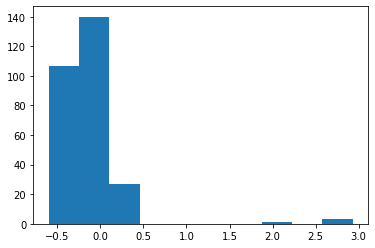

In [93]:
# Plot distribution of first tic for first frames for all data
plt.hist([traj[0, 0] for traj in tica_output]) 
# Distribution does not looks the same for first frame vs all frames, meaning this system is has not equilibrated 

In [ ]:
# TO DO:
# Look at 10 frames with low tics and 10 frames with high tics
# Look at trajectory with largest tic value
# Can also grab every 10 or so frames from smallest tica value to largest, and make a synthetic trajectory, then smooth it in pymol

In [61]:
# Get list of max tic values for each trajectory
maxes = []
for traj in tica_output:
    maxes.append(np.max(traj[:, 0]))

In [62]:
# Get the trajectory with the largest tic value
np.argmax(maxes)

216

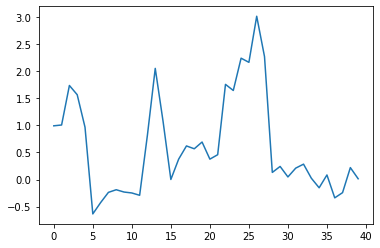

In [63]:
# Plot timeseries of the first tic for trajectory 216
plt.plot(tica_output[216][:,0]) 

## Now, let's cluster the tics

In [73]:
clusters = pyemma.coordinates.cluster_kmeans(tica_output, k=50, max_iter=100)
# k -- choose 50 or 100 to start depending on how big the dataset is
# max_iter = use 10 or 100 depending on dataset size

100%|██████████| 50/50 [00:00<00:00, 148.56it/s]                             

100%|██████████| 100/100 [00:01<00:00, 51.52it/s]


In [78]:
cluster_output = clusters.dtrajs

100%|██████████| 1000/1000 [00:04<00:00, 205.03it/s]                                   


In [79]:
cluster_output

[array([21, 35, 21, 21, 21, 28, 41, 28, 32, 21,  5, 28, 28, 21, 14, 21, 28,
        45, 21,  5, 28, 13, 21, 21, 21, 28, 28, 28, 28, 44, 28, 21, 28, 21,
        37, 25], dtype=int32),
 array([16,  7, 13, 11, 40, 11, 20, 41, 35, 37, 37,  1, 44, 28, 27, 13, 45,
        41, 28,  9,  9,  9, 28, 44, 39, 45, 41, 42, 41, 41,  5, 41, 31, 44,
        11, 16, 36, 16, 16, 16, 16, 16, 16, 16, 16, 16, 36, 36],
       dtype=int32),
 array([ 4, 25,  8,  8, 25, 12, 37,  8, 25,  4, 44, 21, 28, 37, 28, 32, 45,
        21, 21, 21,  0, 21], dtype=int32),
 array([ 8,  8, 12,  4,  4, 26, 37, 32, 32, 40, 13, 44, 35, 27, 41, 28,  0,
         9, 44, 18], dtype=int32),
 array([32, 21, 28, 21,  5, 21, 24,  9, 15,  0,  0, 28,  7, 13, 21, 41,  0,
        45,  7,  7, 45, 23,  7,  5, 37, 44,  0,  0, 32, 34,  0,  0, 34,  0,
        37, 24,  0,  9, 15, 32, 39,  5, 41,  9], dtype=int32),
 array([21, 21, 41,  5, 45, 41, 41, 42,  2, 29,  2, 45, 41, 41, 41, 41, 41,
        41, 41, 41, 41, 45, 41, 10, 41, 41, 41, 45, 41, 41

In [80]:
# Compute implied timescales -- computes multiple msms at diff lag times
its = pyemma.msm.its(cluster_output) 

100%|██████████| 7/7 [00:01<00:00,  3.99it/s]                                 


<AxesSubplot:xlabel='lag time / steps', ylabel='timescale / steps'>

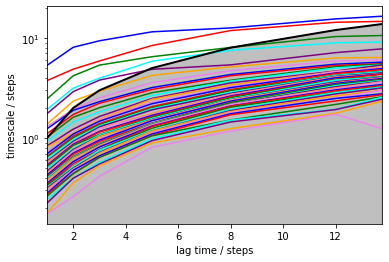

In [81]:
pyemma.plots.plot_implied_timescales(its) 
# Each line corresponds to a slow process (number processes = number of clusters - 1, so 49)
# Gray area -- lag time has become longer than the timescale of the process
# If we want to make an msm based on this data, we need to use lag time < 12 because its hitting gray region there
# perhaps these distances are not good descriptors of the slowest process because these distances describe a pretty fast timescale


## Build MSM

In [82]:
msm = pyemma.msm.estimate_markov_model(cluster_output, 7) 
# Alternatives to `estimate_markov_model`: hidden - coarse grained, augumented - with experimental data
# Choose 7 as lag time because it looks flat after lag time 7

In [84]:
msm.active_state_fraction 
# This you how many states we've kept (here, we've kept all state)
# Sometimes states are discarded if there are no transitions in both directions for that state

1.0

In [86]:
msm.eigenvectors_right 
# eigenvectors_left -- eigenvectors multiplied by the populations
# eigenvectors_right -- eigenvectors themselves

<bound method MSM.eigenvectors_right of MaximumLikelihoodMSM(connectivity='largest', core_set=None,
           count_mode='sliding', dt_traj='1 step', lag=7, maxerr=1e-08,
           maxiter=1000000, milestoning_method='last_core',
           mincount_connectivity='1/n', reversible=True, score_k=10,
           score_method='VAMP2', sparse=False, statdist_constraint=None)>

In [87]:
eigenvectors = msm.eigenvectors_right()

In [88]:
eigenvectors.shape # dimensions: states, value of eigenvector


(50, 50)

In [90]:
# Let's check that we have the dimensions right
eigenvectors[:, 0] # First eigenvector is equilibrium should be flat 

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

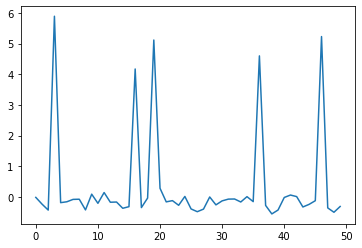

In [91]:
# Plot slowest eigenvector vs. states
plt.plot(eigenvectors[:,1]) # slowest eigenvector
# There's 5 microstates that form one macrostate, all the rest are another macrostate --> 2 macrostates

In [ ]:
# TODO:
# Can look at which state has the lowest vs highest -- in pymol
# What is the difference in distributions in the 5 states with spikes